In [1]:
import tensorflow as tf
from sklearn.metrics import mean_squared_error, euclidean_distances, median_absolute_error
import numpy as np
import pandas as pd
from astroNN.nn.layers import MCDropout
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import scipy.integrate as intg

# Short dataset

In [2]:
model = tf.keras.models.load_model('models/short_lsst_data_model.h5', custom_objects={'MCDropout': MCDropout})

In [3]:
data_folder = 'Data_SNIa_LSST/'
df_data = pd.read_csv(data_folder+'hubble_diagram_Pr.txt', skiprows=4, sep=' ')
# Np = len(dfp.values)
# N s=  len(dfs.values)
df_data.head()

,zCMB,zHEL,MU,MUERR,MUERR_SYS
0,0.04131,0.04131,36.31666,0.00969,0.00674
1,0.06876,0.06876,37.44798,0.00541,0.00627
2,0.13121,0.13121,38.94492,0.01969,0.00868
3,0.18499,0.18499,39.75545,0.01338,0.00658
4,0.24503,0.24503,40.42469,0.01068,0.00590


In [4]:
df_data['errors'] = df_data['MUERR'].values+df_data['MUERR_SYS'].values
df_data.head()

,zCMB,zHEL,MU,MUERR,MUERR_SYS,errors
0,0.04131,0.04131,36.31666,0.00969,0.00674,0.01643
1,0.06876,0.06876,37.44798,0.00541,0.00627,0.01168
2,0.13121,0.13121,38.94492,0.01969,0.00868,0.02837
3,0.18499,0.18499,39.75545,0.01338,0.00658,0.01996
4,0.24503,0.24503,40.42469,0.01068,0.00590,0.01658


In [5]:
df_data = df_data[['zCMB', 'MU', 'errors']]

In [6]:
z_or = df_data[['zCMB']].values
y = df_data[['MU', 'errors']].values
zmin, zmax = np.min(z_or), np.max(z_or)


In [7]:
scalerz = StandardScaler()
scalerz.fit(z_or.reshape(-1,1))
# apply transform
z = scalerz.transform(z_or.reshape(-1,1))

In [8]:
# Generate test data
# test_batch_size = 500
test_batch_size = len(z)
x_test = z

mc_dropout_num = 100 # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(z_or.reshape(-1,1)))
#     predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)


1/1 [==============================] - 0s 16ms/step


In [9]:
def RHSquared_a_owacdm(a, w0, wa, Om):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2
    
def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r

### Hay que revisar esta constante en el return
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+24
# +43

# zmodel = np.linspace(0.01, 2.4, 100)
zmodel = z_or
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

om = 0.27
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om))

In [10]:
len(prediction_mc_dropout[:,0]), len(x_test), len(zmodel)

(14, 14, 14)

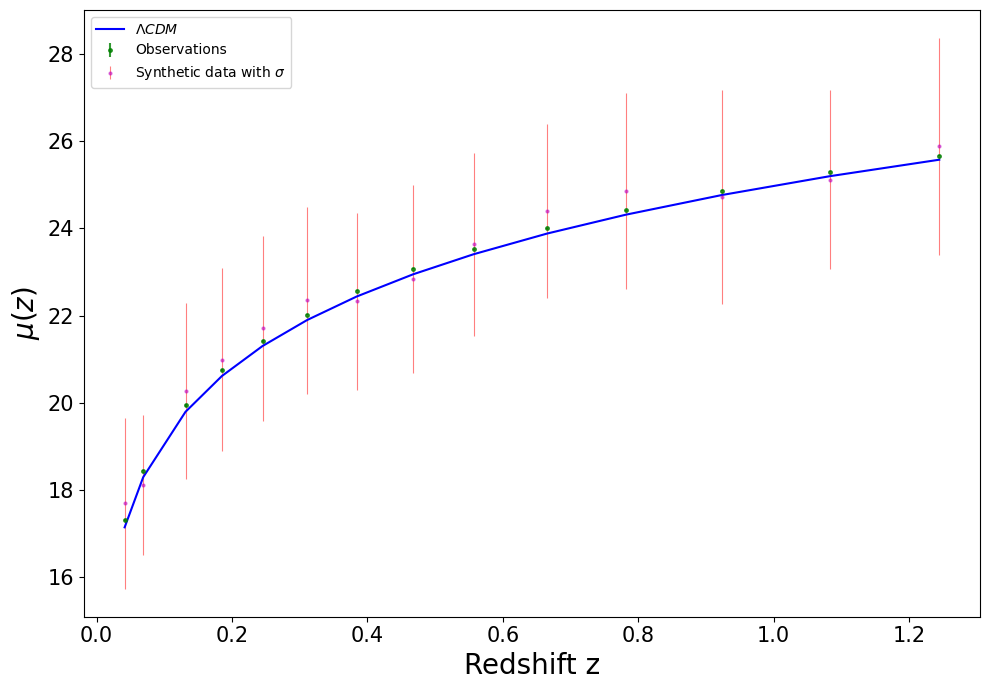

In [11]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(df_data['zCMB'], df_data['MU']-19, df_data['errors'], fmt='g.', markersize=5, alpha=0.8, label='Observations')
plt.errorbar(z_or, prediction_mc_dropout[:,0]-19, yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.5, c='m',
             label='Synthetic data with $\sigma$')

# plt.xlim(zmin-0.01,zmax+0.01)

# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()

In [12]:
# mean_squared_error, euclidean_distances, median_absolute_error
mse_lcdm = mean_squared_error(df_data['MU'].values-19, flcdm)
mse_neural = mean_squared_error(df_data['MU'].values-19, np.sort(prediction_mc_dropout[:,0]-19))
mse_lcdm, mse_neural

(0.015960415567819138, 0.07449602186712119)